In [1]:
from XRDXRFutils import DataXRF

from numpy import arange,linspace
from matplotlib.pyplot import plot,subplots,xlim,ylim,hlines,vlines,xlabel,ylabel

In [2]:
data = DataXRF()

In [3]:
path = '/home/zdenek/Projects/pyMaXRDXRF/M0795/CappelloGialloXRF/'
data.calibrate_from_file('calibration.ini')

/usr/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [4]:
data.calibration.fce

<function XRDXRFutils.data.DataXRF.fce_calibration(x, a, b, c)>

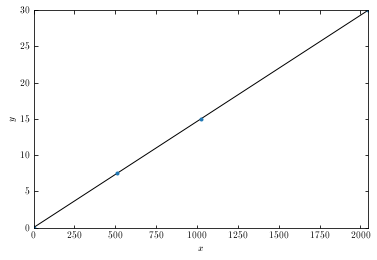

In [5]:
data.calibration.plot()

In [6]:
%%time
data.read(path)

Reading XRF data
Done
CPU times: user 178 ms, sys: 261 ms, total: 439 ms
Wall time: 437 ms


In [7]:
data.save_h5()

Saving: /home/zdenek/Projects/pyMaXRDXRF/M0795/CappelloGialloXRF//data.h5


In [8]:
%%time
data.load_h5(path + 'data.h5')

Loading: /home/zdenek/Projects/pyMaXRDXRF/M0795/CappelloGialloXRF/data.h5
CPU times: user 4.71 ms, sys: 185 ms, total: 189 ms
Wall time: 186 ms


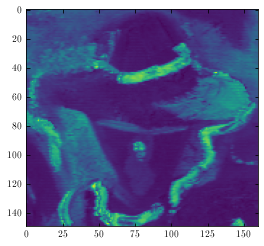

In [9]:
from matplotlib.pyplot import imshow
imshow(data.data.sum(-1)[::-1])

Text(0, 0.5, 'counts')

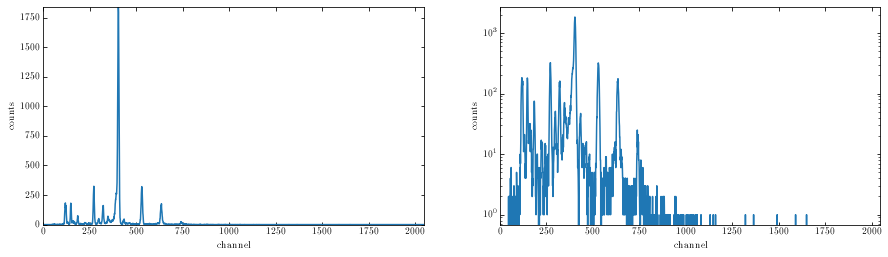

In [10]:
fig,ax = subplots(1,2,figsize=(15,4))
y = data.data[100,101]

ax[0].plot(y)
ax[0].set_xlim(0,2048)
ax[0].set_ylim(0,y.max())
ax[0].set_xlabel('channel')
ax[0].set_ylabel('counts')

ax[1].semilogy(y)
ax[1].set_xlim(0,2048)
ax[1].set_xlabel('channel')
ax[1].set_ylabel('counts')

Text(0, 0.5, 'counts')

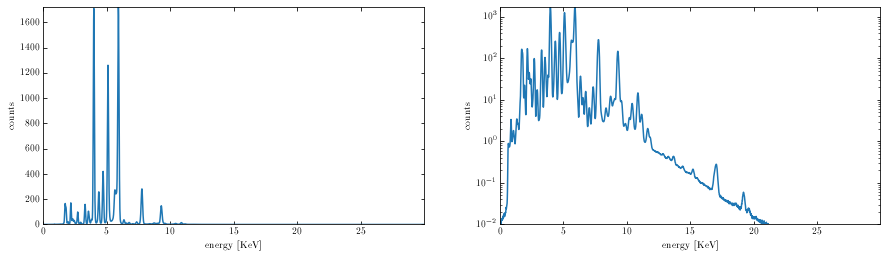

In [11]:
fig,ax = subplots(1,2,figsize=(15,4))
y = data.data.mean(0).mean(0)
x = data.x

ax[0].plot(x,y)
ax[0].set_xlim(0,x.max())
ax[0].set_ylim(0,y.max())
ax[0].set_xlabel('energy [KeV]')
ax[0].set_ylabel('counts')

ax[1].semilogy(x,y)
ax[1].set_xlim(0,x.max())
ax[1].set_ylim(1e-2,y.max())
ax[1].set_xlabel('energy [KeV]')
ax[1].set_ylabel('counts')

In [12]:
from scipy.interpolate import interp1d
from numpy import concatenate,append,array,diff,trapz

In [13]:
def __resample_x(x,nbins=1024,bounds=(0,30)):
    
    new_x = linspace(*bounds,nbins)   
    
    fx = []
    gx = []

    ax = new_x[0]
    
    for bx in new_x[1:]:
        
        f = (x > ax) & (x < bx)
        
        gx += [array([ax,*x[f],bx])]
        fx += [f]

        ax = bx
               
    return new_x,fx,gx

def __resample_y(x,y,new_x,fx,gx):
    
    f = interp1d(x,y,fill_value='extrapolate')
    new_y = f(new_x)

    iy = []
    ay = new_y[0]
    for f,_gx,by in zip(fx,gx,new_y[1:]):

        gy = array([ay,*y[f],by])
        iy += [trapz(gy,_gx)]
        
        ay = by
        
    iy = array(iy)
               
    return iy

In [14]:
x = data.x
y = data.data.mean(0).mean(0)

In [15]:
%%time
new_x,fx,gx = __resample_x(x)
ix = (new_x[:-1] + new_x[1:]) * 0.5
for i in range(200):
    iy = __resample_y(x,y,new_x,fx,gx)

CPU times: user 3.13 s, sys: 1.65 ms, total: 3.13 s
Wall time: 3.12 s


Text(0, 0.5, 'counts')

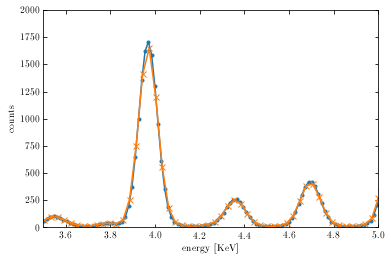

In [16]:
plot(x,y,'.-')
b = ix[1] - ix[0]
plot(ix,iy / b,'x-')

xlim(3.5,5)
ylim(0,2000)
xlabel('energy [KeV]')
ylabel('counts')

In [17]:
def resample(x,y,nbins=1024,bounds=(0,30)):
    
    f = interp1d(x,y,fill_value='extrapolate')
    
    new_x = linspace(*bounds,nbins)
    new_y = f(new_x)
    
    ax = new_x[0]
    ay = new_y[0]
    
    ix = []
    iy = []

    for bx,by in zip(new_x[1:],new_y[1:]):
        f = (x > ax) & (x < bx)

        gx = array([ax,*x[f],bx])
        gy = array([ay,*y[f],by])

        ix += [(ax + bx) * 0.5]
        iy += [trapz(gy,gx)]

        ax = bx
        ay = by
        
    ix = array(ix)
    iy = array(iy)
               
    return ix,iy

In [18]:
x = data.x
y = data.data.mean(0).mean(0)

In [19]:
%%time
for i in range(200):
    ix,iy = resample(x,y)

CPU times: user 5 s, sys: 0 ns, total: 5 s
Wall time: 5 s


905.000270106607
905.0002701066072
905.000270106606
905.0002701066077
905.0002701066066
905.0002701066079
905.0002701066063
905.0002701066055


Text(0, 0.5, 'counts')

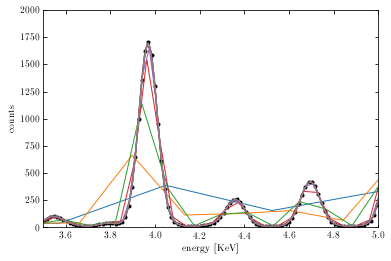

In [20]:
plot(x,y,'k.-')

for n in [64,128,256,512,1024,2048,4096,8192]:
    ix,iy = resample(x,y,n)
    b = ix[1] - ix[0]
    print(sum(iy))
    
    plot(ix,iy / b,'-',lw=1)

#xlim(5.6,6.2)
xlim(3.5,5)
ylim(0,2000)
xlabel('energy [KeV]')
ylabel('counts')